## Are fitted distributions concordant across pathologies?
### Author: Deb Debnath

#### Data loading

In [22]:
import warnings
import ipywidgets as widgets
from typing import Optional, Sequence

In [23]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent.resolve()))

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from src.classifier import z_score
from src.dist_fitting import (
        test_gamma_fit, 
        test_lognormal_fit_ks, 
        test_negative_binomial_fit
)
from src.random_sample import (
    sample_negative_binomial_mean_rsd,
    sample_gamma_mean_rsd,
    sample_lognormal_mean_rsd
)

In [25]:
raw_data = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=1
)
pathos = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=0
)

In [26]:
pathos = pathos.set_index("Isolate ID")
raw_data = raw_data.set_index("gene_id")

#### Setting parameters

In [27]:
mean_TPM = 0

In [28]:
num_patients = 243
n_samples = 1000
uncertainties = [10, 25, 50]

In [29]:
seed = 321

In [30]:
np.random.seed(seed)

#### Data preprocessing

In [31]:
pathos = pathos.dropna()
pathos = pathos.loc[pathos.index.dropna(), :]
pathos.index = pathos.index.astype(int).astype(str)

In [32]:
patients_df = raw_data[~raw_data.loc[:, "Coeff"].isnull()]
coefficients = np.nan_to_num(np.array(patients_df.loc[:, "Coeff"]))
patients_df = patients_df.filter(regex=r"^\d+")
genes = patients_df.index.values

In [33]:
grouped_cols = patients_df.columns.str.split("-").str[0]
grouped = patients_df.groupby(grouped_cols, axis=1)
patients_df = grouped.apply(lambda x: x.mean(axis=1)).reset_index(drop=True)
patients_df.index = genes

/tmp/ipykernel_812527/2035580270.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = patients_df.groupby(grouped_cols, axis=1)


In [34]:
for col in patients_df.columns:
    if col not in pathos.index:
        print(col)

17906


In [35]:
for col in pathos.index:
    if col not in patients_df.columns:
        pathos = pathos.drop(col)

In [36]:
# Assuming NCI for 17906 (missing from pathos data)
pathos.loc["17906"] = "NCI"

In [37]:
patients_df = patients_df.loc[:, pathos.index]

#### Conversion to Z-scores and dropping genes below TPM threshold

In [38]:
means = patients_df.mean(axis=1)
stds = patients_df.std(axis=1)

In [39]:
z_scores_df = patients_df.apply(lambda x: z_score(x, means, stds))

In [40]:
z_scores_df = z_scores_df[means >= mean_TPM]
coefficients = coefficients[means >= mean_TPM]
patients_df = patients_df[means >= mean_TPM]

A **differentially classified subject** is a subject (patient) that has one or more simulated scores that produced a different classification into AD/NCI than the actual score.

## Goodness of fit criteria

### 1. Kolmogorov–Smirnov (KS) Test

The KS test measures the maximum distance between the empirical CDF of the data and the CDF of the fitted model. A high p-value suggests that the model is a good fit (i.e. there is no significant difference).

### 2. Anderson–Darling (AD) Test

The AD test is similar in spirit to the KS test but gives extra weight to the tails of the distribution. 

### 3. Akaike Information Criterion (AIC)

### Prep

In [20]:
nci_filt = (pathos == "NCI")

In [21]:
nci_subset = patients_df.loc[:, pathos[nci_filt.values].index]
ad_subset = patients_df.loc[:, pathos[~nci_filt.values].index]

### Checking for concordance by considering only Negative binomial, lognormal and gamma distributions

For comparing between the three, distribution-specific goodness of fit metrics are used - 
- p-value for the KS test for negative binomial and gamma distributions
- p-value for the KS test for the lognormal distribution.

**NB**: The Shapiro-Wilk test can also be used for a test for the lognormal distribution, however the test is stricter than the KS test for normality.

#### Overall

In [22]:
def _find_best_dist(lognormal_ks_p_val: Optional[float], gamma_ks_p_val: Optional[float], nb_ks_p_val: Optional[float]) -> Optional[str]:
    p_val_cutoff = 0.1
    subset = pd.Series(index=["lognormal", "negative binomial", "gamma"], data=[lognormal_ks_p_val, gamma_ks_p_val, nb_ks_p_val])
    subset = subset.dropna()
    if len(subset) == 0:
        return None
    subset = subset[subset >= p_val_cutoff]
    if len(subset) == 0:
        return None
    filt = (subset == subset.max())
    return subset[filt].index[0].upper()


def find_best_fit_dist(*, 
                       lognormal_ks_p_vals: pd.Series, 
                       gamma_ks_p_vals: pd.Series,
                       nb_ks_p_vals: pd.Series,
                       means: pd.Series, 
                       stds: pd.Series) -> pd.DataFrame:
    res = pd.DataFrame(index=lognormal_ks_p_vals.index, columns=["vmr", "best_fit", "gamma_ks_p_val", "lognormal_sw_p_val", "nb_ks_p_val"])
    for gene in res.index:
        res.loc[gene, "vmr"] = stds[gene]**2.0 / means[gene]
        res.loc[gene, "best_fit"] = _find_best_dist(lognormal_ks_p_vals[gene], gamma_ks_p_vals[gene], nb_ks_p_vals[gene])
        res.loc[gene, ["lognormal_ks_p_val", "gamma_ks_p_val", "nb_ks_p_val"]] = lognormal_ks_p_vals[gene], gamma_ks_p_vals[gene], nb_ks_p_vals[gene]
    return res

In [23]:
warnings.filterwarnings("ignore")
dist_fitting_results = find_best_fit_dist(lognormal_ks_p_vals=patients_df.apply(lambda row: test_lognormal_fit_ks(row)[1], axis=1),
                                          gamma_ks_p_vals=patients_df.apply(lambda row: test_gamma_fit(row)[1], axis=1),
                                          nb_ks_p_vals=patients_df.apply(lambda row: test_negative_binomial_fit(row)[1], axis=1), 
                                          means=means, stds=stds)

Text(0.5, 1.0, 'Best fit distributions according to p-values')

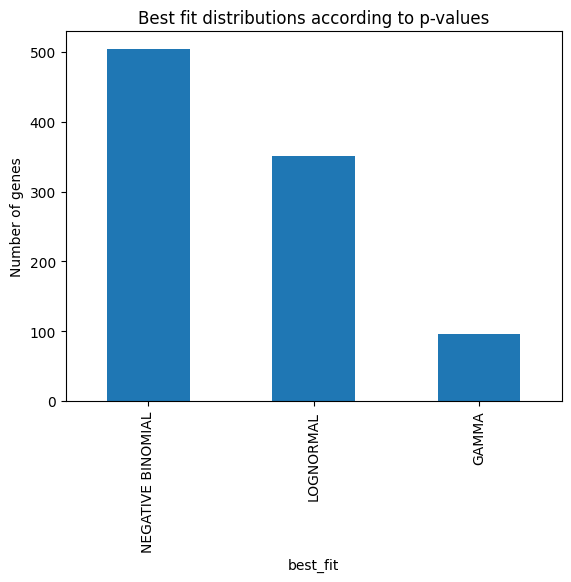

In [24]:
vc = dist_fitting_results["best_fit"].value_counts()
vc.plot.bar()
plt.ylabel("Number of genes")
plt.title("Best fit distributions according to p-values")

#### AD and NCI

In [25]:
dist_fitting_results_ad = find_best_fit_dist(lognormal_ks_p_vals=ad_subset.apply(lambda row: test_lognormal_fit_ks(row)[1], axis=1),
                                            gamma_ks_p_vals=ad_subset.apply(lambda row: test_gamma_fit(row)[1], axis=1),
                                            nb_ks_p_vals=ad_subset.apply(lambda row: test_negative_binomial_fit(row)[1], axis=1), 
                                            means=means, stds=stds)

In [26]:
dist_fitting_results_nci = find_best_fit_dist(lognormal_ks_p_vals=nci_subset.apply(lambda row: test_lognormal_fit_ks(row)[1], axis=1),
                                            gamma_ks_p_vals=nci_subset.apply(lambda row: test_gamma_fit(row)[1], axis=1),
                                            nb_ks_p_vals=nci_subset.apply(lambda row: test_negative_binomial_fit(row)[1], axis=1), 
                                            means=means, stds=stds)

In [27]:
vc = dist_fitting_results["best_fit"].value_counts()
vc_ad = dist_fitting_results_ad["best_fit"].value_counts()
vc_nci = dist_fitting_results_nci["best_fit"].value_counts()

In [28]:
vc_ad = vc_ad[vc.index]
vc_nci = vc_nci[vc.index]

In [29]:
width = 0.3

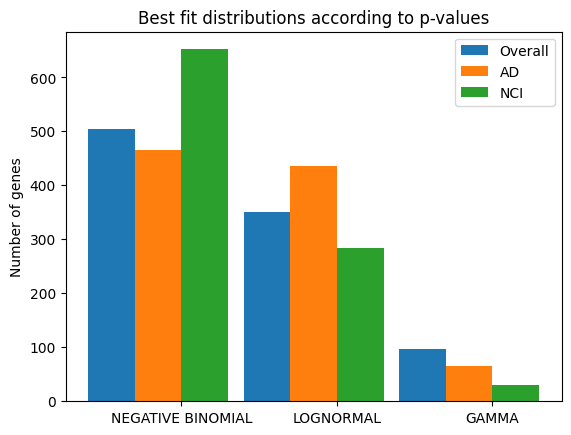

In [30]:
plt.bar(np.arange(3), vc, width, label="Overall")
plt.bar(np.arange(3)+width, vc_ad, width, label="AD")
plt.bar(np.arange(3)+2*width, vc_nci, width, label="NCI")
plt.xticks(np.arange(3)+1.5*width, vc.index)
plt.ylabel("Number of genes")
plt.legend()
plt.title("Best fit distributions according to p-values")
plt.savefig("p_value_best_fit.png")

In [31]:
dist_wise_concordance = pd.DataFrame(index=["NEGATIVE BINOMIAL", "GAMMA", "LOGNORMAL"], columns=["Number of concordant genes", "Number of discordant genes"])
for dist in dist_wise_concordance.index:
    ad_filt = dist_fitting_results_ad["best_fit"] == dist
    nci_filt = dist_fitting_results_nci["best_fit"] == dist
    ad_genes, nci_genes = set(ad_filt[ad_filt].index), set(nci_filt[nci_filt].index)
    dist_wise_concordance.loc[dist, "Number of concordant genes"] = len(ad_genes.intersection(nci_genes))
    dist_wise_concordance.loc[dist, "Number of discordant genes"] = len((ad_genes - nci_genes).union(nci_genes - ad_genes))
dist_wise_concordance

,Number of concordant genes,Number of discordant genes
NEGATIVE BINOMIAL,391,336
GAMMA,7,83
LOGNORMAL,188,343


In [32]:
na_overall, na_ad, na_nci = dist_fitting_results["best_fit"].isna().sum(), dist_fitting_results_ad["best_fit"].isna().sum(), dist_fitting_results_nci["best_fit"].isna().sum()
print(f"{na_overall} ({na_overall/dist_fitting_results.shape[0]*100:.2f}%) (overall), {na_ad} ({na_ad/dist_fitting_results.shape[0]*100:.2f}%) (AD) and {na_nci} ({na_nci/dist_fitting_results.shape[0]*100:.2f}%) (NCI) genes had 'None' - no best fit genes.")

16 (1.65%) (overall), 0 (0.00%) (AD) and 0 (0.00%) (NCI) genes had 'None' - no best fit genes.


## Sampling from Best Fit Distributions (Subject level)

As from [this](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2014-15-2-r29) paper, the relationship between the standard deviation and the mean can be modeled as

$$
\sqrt{\sigma} = \frac{a}{b + \mu} + c
$$

where $\mu$ and $\sigma$ are mean of the log2(1+TPM) dataset and standard deviation of the TPM dataset, respectively and $a$, $b$, $c$ are constants.

We start with values of $a$ = 0.75, $b$ = 1.0, $c$ = 0.25.

In [118]:
def calculate_scaled_sd(tpm: float, a: float, b: float, c: float, uncertainty_pct: int|float) -> float:
    """
    Calculate scaled standard deviation to simulate based on sqrt sigma = a / (b + mu) + c
    """
    sqrt_sigma = a / (np.log2(tpm+1) + b) + c
    return uncertainty_pct * sqrt_sigma**2.0 / 100.0

In [154]:
def plot_histogram_gene_samples_adaptive_sd(
                            patients_df: pd.DataFrame,
                            uncertainties: list[int], 
                            n_samples: int, 
                            i: int,
                            a_val: float,
                            b_val: float,
                            c_val: float):
    gene = patients_df.index[i]
    row = patients_df.loc[gene, :].sort_values().values
    mean_gene = np.mean(patients_df.iloc[i, :])
    quantiles = np.percentile(row, [1, 25, 50, 75, 99])
    labels = ["lower fence", "25th percentile", "50th percentile", "75th percentile", "upper fence"]
    
    # fig, axs = plt.subplots(nrows=len(uncertainties), ncols=2, sharex=True, sharey=True, figsize=(15, 10))
    fig, axs = plt.subplots(nrows=len(uncertainties), ncols=1, sharex=True, sharey=True, figsize=(15, 10))
    leg_handles, leg_labels = None, None    # Legend handles and labels
    for count, uncertainty in enumerate(uncertainties):
        scaled_sd = calculate_scaled_sd(quantiles, a_val, b_val, c_val, uncertainty)
        samples = np.pow(2.0, np.random.normal(np.log2(quantiles+1), scaled_sd, (n_samples, len(quantiles))))

        # plt.subplot(len(uncertainties), 2, 2*count+1)
        plt.subplot(len(uncertainties), 1, count+1)
        # Plot histograms of sampled data            
        for i in range(samples.shape[1]):
            plt.hist(samples[:, i], bins=30, alpha=0.5, label=labels[i])
        plt.title(f"{uncertainty}% uncertainty, scaled")

        # plt.subplot(len(uncertainties), 2, 2*count+2)
        # for i, quantile in enumerate(quantiles):
            # sample = sample_lognormal_mean_rsd(quantile, uncertainty/100, n_samples)
            # plt.hist(sample, bins=30, alpha=0.5, label=labels[i])
        # plt.title(f"{uncertainty}% uncertainty, unscaled")
        if leg_handles is None and leg_labels is None:
            leg_handles, leg_labels = plt.gca().get_legend_handles_labels()

    # Legend
    fig.legend(leg_handles, leg_labels, loc='upper center', ncol=len(leg_labels), bbox_to_anchor=(0.5, 0.08))
    fig.text(0.5, 0.08, 'Simulated TPM counts', va='center', ha="center") 
    fig.text(0.08, 0.5, 'Counts', va='center', ha="center", rotation="vertical")        
    plt.suptitle(f"Effect of adaptive standard deviation on sampled data for gene {gene}")

[]

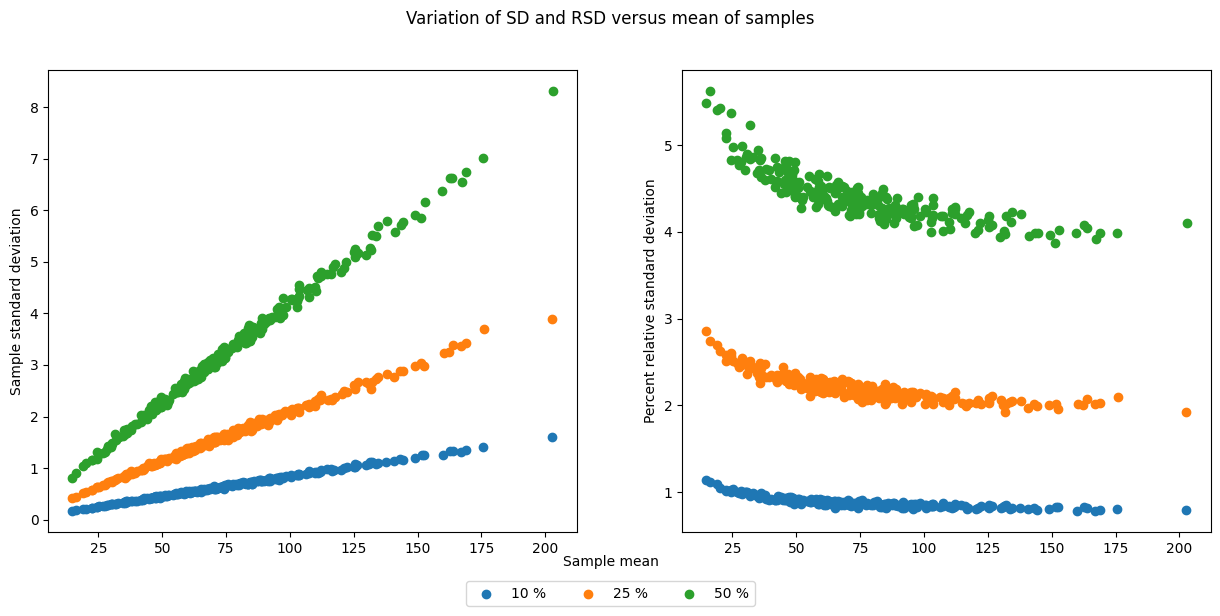

In [155]:
gene_idx = np.random.randint(0, patients_df.shape[0])
row  = patients_df.iloc[gene_idx]
fig = plt.figure(figsize=(15, 6))
for uncert in [10, 25, 50]:
    scaled_sd = calculate_scaled_sd(row, 0.75, 1.0, 0.25, uncert)
    samples = np.pow(2.0, np.random.normal(np.log2(row+1), scaled_sd, (n_samples, len(row))))
    plt.subplot(121)
    plt.scatter(samples.mean(axis=0), samples.std(axis=0), label=f"{uncert} %")
    plt.subplot(122)
    plt.scatter(samples.mean(axis=0), samples.std(axis=0)/samples.mean(axis=0) * 100, label=f"{uncert} %")
plt.subplot(121)
plt.ylabel("Sample standard deviation")
plt.subplot(122)
plt.ylabel("Percent relative standard deviation")

leg_handles, leg_labels = plt.gca().get_legend_handles_labels()
fig.legend(leg_handles, leg_labels, loc='upper center', ncol=len(leg_labels), bbox_to_anchor=(0.5, 0.04))
fig.suptitle("Variation of SD and RSD versus mean of samples")
fig.text(0.5, 0.06, 'Sample mean', va='center', ha="center") 
plt.plot()

In [156]:
def wrapper_func(gene_idx: int, a: float, b: float, c: float):
    plot_histogram_gene_samples_adaptive_sd(patients_df, [10, 25, 50], n_samples, gene_idx, a, b, c)
gene_idx_slider = widgets.IntSlider(min=0, max=patients_df.shape[0]-1, step=1, value=0, description='Gene index:', 
                             disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='d')
a_slider = widgets.FloatSlider(min=0.0, max=100.0, step=0.01, value=0.75, description='a:', 
                             disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f', layout=widgets.Layout(width='500px'))
b_slider = widgets.FloatSlider(min=0.0, max=100.0, step=0.01, value=1.0, description='b:', 
                             disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f', layout=widgets.Layout(width='500px'))
c_slider = widgets.FloatSlider(min=0.0, max=100.0, step=0.01, value=0.25, description='c:', 
                             disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f', layout=widgets.Layout(width='500px'))
widgets.interactive(wrapper_func, gene_idx=gene_idx_slider, a=a_slider, b=b_slider, c=c_slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Gene index:', max=966), FloatSl…

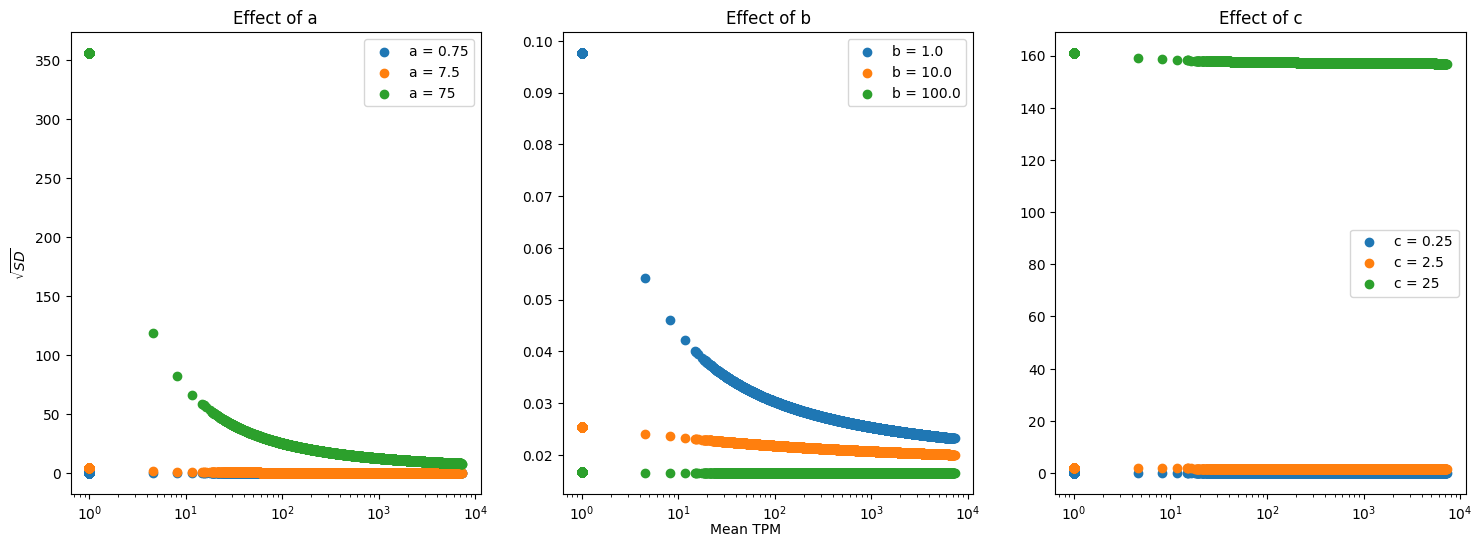

In [150]:
x = np.linspace(1, patients_df.max(), 100)
fig = plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.scatter(x, calculate_scaled_sd(x, 0.75, 1.0, 0.25, 25), label="a = 0.75")
plt.scatter(x, calculate_scaled_sd(x, 7.5, 1.0, 0.25, 25), label="a = 7.5")
plt.scatter(x, calculate_scaled_sd(x, 75, 1.0, 0.25, 25), label="a = 75")
plt.semilogx()
plt.ylabel(r"$\sqrt{SD}$")
plt.legend()
plt.title("Effect of a")
plt.subplot(132)
plt.scatter(x, calculate_scaled_sd(x, 0.75, 1.0, 0.25, 25), label="b = 1.0")
plt.scatter(x, calculate_scaled_sd(x, 0.75, 10.0, 0.25, 25), label="b = 10.0")
plt.scatter(x, calculate_scaled_sd(x, 0.75, 100.0, 0.25, 25), label="b = 100.0")
plt.semilogx()
plt.legend()
plt.title("Effect of b")
plt.subplot(133)
plt.scatter(x, calculate_scaled_sd(x, 0.75, 1.0, 0.25, 25), label="c = 0.25")
plt.scatter(x, calculate_scaled_sd(x, 0.75, 1.0, 2.5, 25), label="c = 2.5")
plt.scatter(x, calculate_scaled_sd(x, 0.75, 1.0, 25, 25), label="c = 25")
plt.semilogx()
plt.legend()
plt.title("Effect of c")
fig.text(0.5, 0.05, "Mean TPM", va='center', ha="center")        
plt.show()